In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import re
import pandas as pd
from bs4 import BeautifulSoup
import spacy
import ast


warnings.filterwarnings('ignore')
import IPython.display



In [2]:
# -------------------------------
# 1. Chargement des données
# -------------------------------
data = pd.read_csv('QueryResults.csv')


In [3]:
data

,Id,CreationDate,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
0,11227809,2012-06-27 13:51:36,Why is processing a sorted array faster than p...,"<p>In this C++ code, sorting the data (<em>bef...",<java><c++><performance><cpu-architecture><bra...,27452,1936893,NaN,25
1,2003505,2010-01-05 01:12:15,How do I delete a Git branch locally and remot...,<p>Failed Attempts to Delete a Remote Branch:<...,<git><version-control><git-branch><git-push><g...,20365,12775117,NaN,41
2,1642028,2009-10-29 06:57:45,What is the '-->' operator in C/C++?,"<p>After reading <a href=""http://groups.google...",<c++><c><operators><code-formatting><standards...,10232,1034429,NaN,26
3,1125968,2009-07-14 14:58:15,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...,9885,9248770,NaN,55
4,79923,2008-09-17 04:18:06,What and where are the stack and heap?,<ul>\n<li>What are the stack and heap?</li>\n<...,<data-structures><memory-management><heap-memo...,9537,2005857,NaN,30
...,...,...,...,...,...,...,...,...,...
9475,33473502,2015-11-02 08:32:36,removing white spaces at beginning and end of ...,<p>I've got a problem with removing whitespace...,<ios><string><swift><whitespace><trim>,5,11386,NaN,10
9476,3560950,2010-08-24 20:54:13,Best language to parse extremely large Excel 2...,<p>My boss has a habit of performing queries o...,<java><excel><scripting><excel-2007><apache-poi>,5,15509,NaN,10
9477,12910697,2012-10-16 08:41:43,How to connect the device to Eclipse?,<p>I am not able to resolve this simple issue....,<android><eclipse><android-emulator><device><g...,5,37204,NaN,13
9478,20169545,2013-11-24 00:10:29,Codeigniter 3 Remove index.php Problems,<p>I have a little project that i developed fo...,<php><apache><.htaccess><codeigniter><mod-rewr...,5,22611,NaN,10


In [4]:
# Taille du dataset
print(f"Nombre de questions : {data.shape[0]}")

# Liste des colonnes
print("Colonnes :", data.columns.tolist())

# Statistiques de base
data.describe(include='all')

# Nombre de tags par question
data['Tags_count'] = data['Tags'].str.count('<')  # Chaque tag est entre <>
data['Tags_count'].value_counts().sort_index()


Nombre de questions : 9480
Colonnes : ['Id', 'CreationDate', 'Title', 'Body', 'Tags', 'Score', 'ViewCount', 'FavoriteCount', 'AnswerCount']


Tags_count
5    9480
Name: count, dtype: int64

In [5]:
def test_completion(data):
    """
    Compute sorted completion rate and number of missing values for each variable of the argument in a descending order
    
    Args:
        data(dataset) : A dataset with variables
        
    Returns:
        A specific dataframe with completion rate for each variable. 
        Schema :
            Index(string): Variable names
            Taux de completion(float): completion rate
            Nombre de valeurs manquantes(int): Number of missing values
    """
    var_dict = {}
    
    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["Taux de complétion", "Nombre de valeurs manquantes"]).sort_values(by="Taux de complétion", ascending=False)

test_completion(data)

,Taux de complétion,Nombre de valeurs manquantes
Id,100.0,0
CreationDate,100.0,0
Title,100.0,0
Body,100.0,0
Tags,100.0,0
Score,100.0,0
ViewCount,100.0,0
AnswerCount,100.0,0
Tags_count,100.0,0
FavoriteCount,0.0,9480


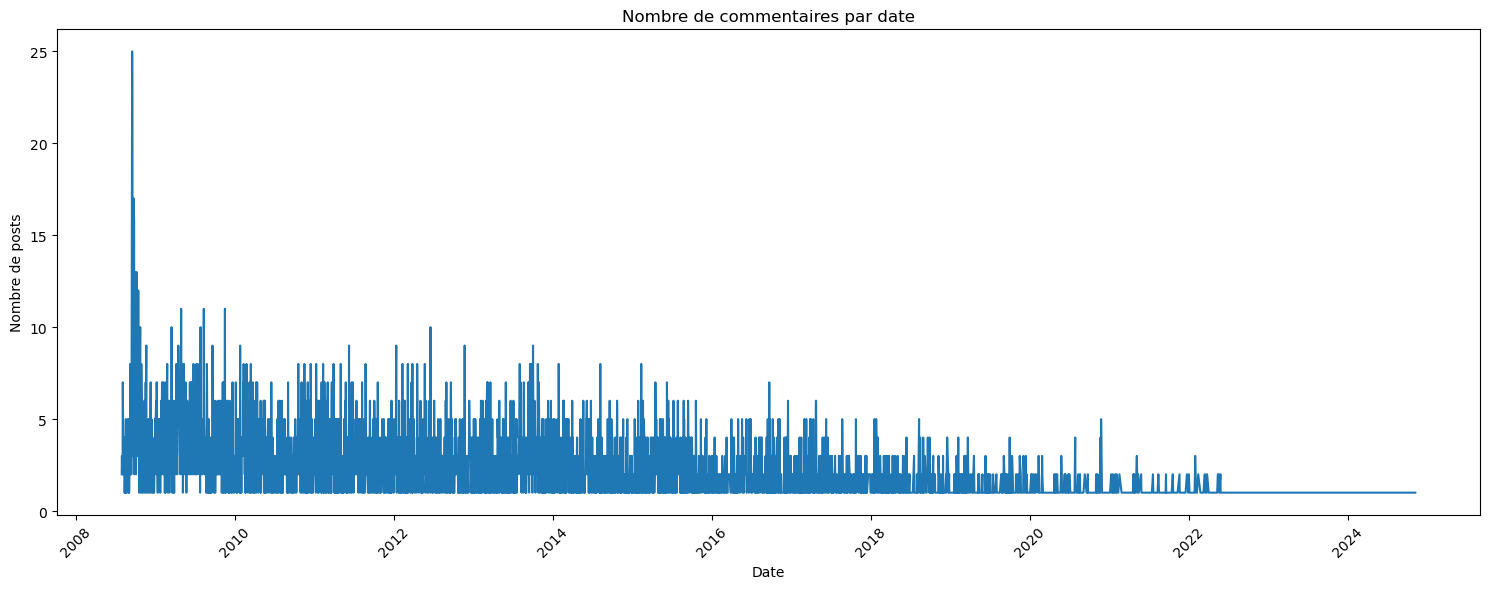

In [6]:
# Conversion explicite en datetime si nécessaire
data['CreationDate'] = pd.to_datetime(data['CreationDate'], errors='coerce')

# Calcul du nombre de créations par jour
CreationDateByDay = data['CreationDate'].dt.date.value_counts().sort_index()

# Affichage
fig, ax = plt.subplots(figsize=(15, 6))  # 50x10 est énorme, 15x6 est mieux
sns.lineplot(x=CreationDateByDay.index, y=CreationDateByDay.values, ax=ax)

ax.set_xlabel("Date")
ax.set_ylabel("Nombre de posts")
ax.set_title("Nombre de commentaires par date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



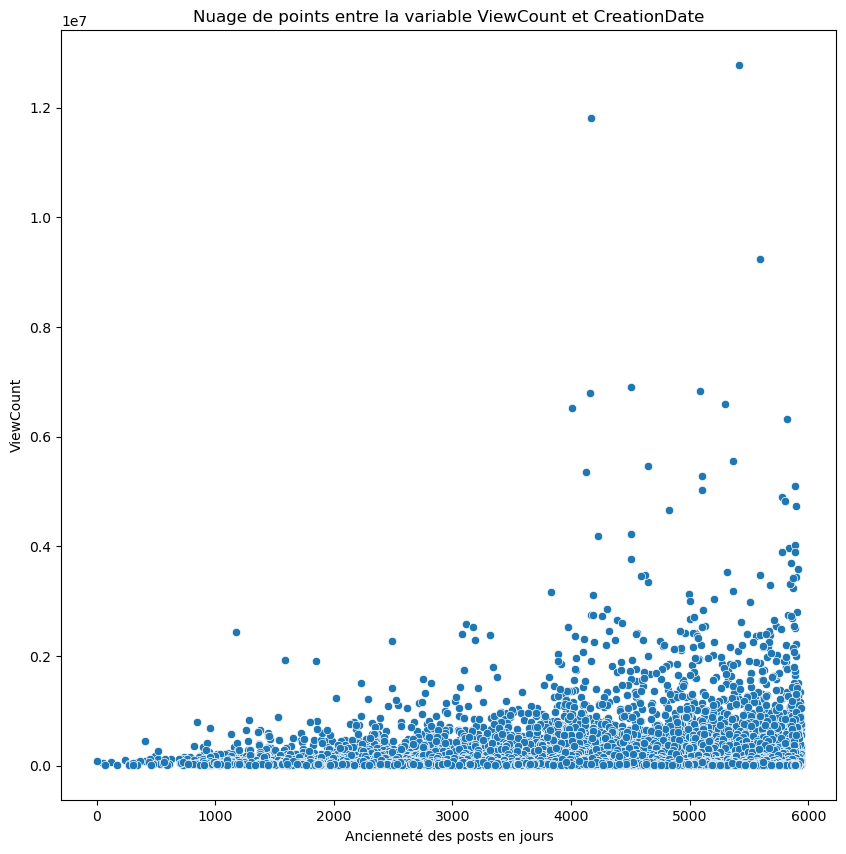

In [7]:
last_post = data["CreationDate"].max()
data["CreationDateTimeDelta"] = last_post - data["CreationDate"]
data["CreationDateTimeDelta"] = data["CreationDateTimeDelta"].dt.days

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
sns.scatterplot(data=data, x="CreationDateTimeDelta", y="ViewCount", ax=ax)
ax.set_xlabel("Ancienneté des posts en jours")
ax.set_label("Nombre de vues")
ax.set_title("Nuage de points entre la variable ViewCount et CreationDate")
plt.show()

### 🧹 Nettoyage du texte

In [9]:
# Charger le modèle spaCy (anglais)
nlp = spacy.load("en_core_web_sm")

# Liste de stop words spaCy
stop_words = nlp.Defaults.stop_words

def clean_text(text):
    if pd.isnull(text):
        return ""
    # 1. Supprimer le HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    # 2. Supprimer espaces multiples et ponctuation (on conserve les mots et espaces)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()

    # 3. Traitement spaCy pour lemmatisation + suppression stopwords + suppression mots <=2 caractères
    doc = nlp(text)
    tokens = []
    for token in doc:
        if (token.is_alpha            # mot alphabétique
            and token.text not in stop_words  # pas un stopword
            and len(token.text) > 2):  # plus de 2 caractères
            tokens.append(token.lemma_)
    return " ".join(tokens)

def clean_and_extract_tags(raw_tags):
    """
    Nettoie et extrait les tags d'une chaîne de caractères ou d'une liste.
    - Gère les cas de chaînes contenant des chevrons : '<python><api>'
    - Gère les cas de listes encodées en string : "['python', 'api']"
    - Met tout en minuscule, retire les doublons, et ignore les valeurs nulles.
    """
    if pd.isnull(raw_tags):
        return []
    
    # Si c’est déjà une liste encodée en string (ex: "['python', 'api']")
    try:
        parsed = ast.literal_eval(raw_tags) if isinstance(raw_tags, str) else raw_tags
        if isinstance(parsed, list):
            return list(set(str(tag).lower() for tag in parsed))
    except:
        pass

    # Sinon, extraire les tags au format <tag>
    tags_list = re.findall(r'<([^>]+)>', str(raw_tags))
    return list(set(tag.lower() for tag in tags_list))


# Application
data['Clean_Title'] = data['Title'].apply(clean_text)
data['Clean_Body'] = data['Body'].apply(clean_text)

data['Full_Text'] = data['Clean_Title'] + " " + data['Clean_Body']

data['Clean_Tags'] = data['Tags'].apply(clean_and_extract_tags)

data[['Full_Text', 'Clean_Tags']].head()


,Full_Text,Clean_Tags
0,process sorted array fast process unsorted arr...,"[java, cpu-architecture, branch-prediction, c+..."
1,delete git branch locally remotely fail attemp...,"[version-control, git-branch, git-remote, git,..."
2,operator read hide feature dark corner cstl co...,"[code-formatting, c, standards-compliance, c++..."
3,force git pull overwrite local file force over...,"[overwrite, git-fetch, version-control, git-pu..."
4,stack heap stack heap locate physically comput...,"[dynamic-memory-allocation, data-structures, m..."


In [10]:
df_clean = data[['Id', 'Full_Text', 'Clean_Tags']]

In [11]:
df_clean

,Id,Full_Text,Clean_Tags
0,11227809,process sorted array fast process unsorted arr...,"[java, cpu-architecture, branch-prediction, c+..."
1,2003505,delete git branch locally remotely fail attemp...,"[version-control, git-branch, git-remote, git,..."
2,1642028,operator read hide feature dark corner cstl co...,"[code-formatting, c, standards-compliance, c++..."
3,1125968,force git pull overwrite local file force over...,"[overwrite, git-fetch, version-control, git-pu..."
4,79923,stack heap stack heap locate physically comput...,"[dynamic-memory-allocation, data-structures, m..."
...,...,...,...
9475,33473502,remove white space beginning end string get pr...,"[trim, string, whitespace, swift, ios]"
9476,3560950,good language parse extremely large excel file...,"[scripting, java, apache-poi, excel, excel-2007]"
9477,12910697,connect device eclipse able resolve simple iss...,"[eclipse, android, galaxy, device, android-emu..."
9478,20169545,codeigniter remove indexphp problem little pro...,"[php, codeigniter, apache, .htaccess, mod-rewr..."


In [12]:
import re

def is_strictly_english(text):
    # Supprimer ponctuation et chiffres pour ne garder que lettres
    non_english_chars = re.findall(r'[^a-zA-Z\s\.,;:!?\'\"()\[\]{}\-]', text)
    return len(non_english_chars) < 2  # on garde uniquement si < 2 caractères non anglais

# Appliquer ce filtre
df_clean = df_clean[df_clean['Full_Text'].apply(is_strictly_english)]

In [13]:
df_clean

,Id,Full_Text,Clean_Tags
0,11227809,process sorted array fast process unsorted arr...,"[java, cpu-architecture, branch-prediction, c+..."
1,2003505,delete git branch locally remotely fail attemp...,"[version-control, git-branch, git-remote, git,..."
2,1642028,operator read hide feature dark corner cstl co...,"[code-formatting, c, standards-compliance, c++..."
3,1125968,force git pull overwrite local file force over...,"[overwrite, git-fetch, version-control, git-pu..."
4,79923,stack heap stack heap locate physically comput...,"[dynamic-memory-allocation, data-structures, m..."
...,...,...,...
9475,33473502,remove white space beginning end string get pr...,"[trim, string, whitespace, swift, ios]"
9476,3560950,good language parse extremely large excel file...,"[scripting, java, apache-poi, excel, excel-2007]"
9477,12910697,connect device eclipse able resolve simple iss...,"[eclipse, android, galaxy, device, android-emu..."
9478,20169545,codeigniter remove indexphp problem little pro...,"[php, codeigniter, apache, .htaccess, mod-rewr..."


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Créer le vectorizer TF-IDF en anglais
vectorizer_tfidf = TfidfVectorizer(stop_words='english', min_df=1)

# Calculer la matrice TF-IDF à partir du texte propre
X_tfidf = vectorizer_tfidf.fit_transform(df_clean['Full_Text'])

# Convertir en DataFrame avec les mots en colonnes
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer_tfidf.get_feature_names_out()
)

# Afficher un aperçu
tfidf_df.head()


,aaa,aaaa,aaaaa,aaaaaa,aaaaanbbbbbnccccc,aaaahhhhha,aaabbb,aaabbbcccddd,aabbccddeeff,aac,...,zurb,zurbs,zxe,zxf,zxing,zxvf,zzz,zzzzz,złtext,сocoapod
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Une extraction Bag-of-Words (TF-IDF) 
🔍 Objectif :
Transformer un texte en vecteurs numériques que les modèles de machine learning peuvent comprendre.

🧰 Méthode choisie ici : Bag-of-Words + TF-IDF
1. 📦 Bag-of-Words (BoW)
Compte la fréquence de chaque mot dans chaque document.

Simple mais efficace pour une première approche.

Ignore la grammaire et l’ordre des mots.

2. 📈 TF-IDF (Term Frequency – Inverse Document Frequency)
Améliore Bag-of-Words en réduisant le poids des mots trop fréquents (comme "the", "function", "use", etc.).

| Variable    | Pourquoi on la garde                                                                                                        |
| ----------- | --------------------------------------------------------------------------------------------------------------------------- |
| `Id`        | Sert d'identifiant unique pour tracer, évaluer ou relier les prédictions à la question d'origine.                           |
| `Full_Text` | C'est **l'entrée du modèle** (texte nettoyé : `Title + Body`). Elle contient toute l'information que l’utilisateur fournit. |
| `Clean_Tags`      | C’est **la cible** à prédire dans la tâche de classification multi-label.                                                   |


| Élement du cahier des charges | Fait ? |
| ----------------------------- | -------------- |
| Nettoyage texte               | ✅              |
| Lemmatisation + stop words    | ✅              |
| Suppression non-anglais       | ✅              |
| Construction Bag-of-Words     | ✅              |
| Pondération TF-IDF            | ✅              |


In [15]:
# Exporter pour les notebooks suivants

df_clean.to_csv('clean_questions.csv', index=False)


In [ ]:
print(type(data['Clean_Tags'].iloc[0]))
print(data['Clean_Tags'].iloc[0])